# Installing Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os
import h5py

import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, DepthwiseConv2D, SeparableConv2D, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import datasets, layers, models

#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.keras.backend.clear_session()

# pre-processing
train_path = '../Covid19-dataset/train'
test_path = '../Covid19-dataset/test'

img_size = 224
batch = 16

# Image loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(img_size, img_size),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator


train_generator = generate_data(train_path)
test_generator = generate_data(test_path)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Modelling

In [3]:
    
def build_model(input_shape):
    input_img = Input(shape=input_shape, name='ImageInput')
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
#     x = SeparableConv2D(64, (3,3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2,2))(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

model = build_model(input_shape=(img_size, img_size, 3))

# def COVID_NET(input_shape=(32, 32, 3)):
#     model = models.Sequential()
#     model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding="same"))
#     model.add(MaxPool2D(2, 2))
#     model.add(Conv2D(32, (3,3), activation='relu', padding="same"))
#     model.add(MaxPool2D(2, 2))
#     model.add(Conv2D(64, (3,3), activation='relu', padding="same"))
#     model.add(MaxPool2D(2, 2))
#     model.add(Dropout(0.3))
#     model.add(Flatten())
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(3, activation='softmax'))
#     return model
# model = COVID_NET(input_shape=(img_size, img_size, 3))

model.summary()    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 112, 112, 32)     1344      
 Conv2D)                                                         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                             

## Callback to save our best model during training

In [4]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('accuracy') > 0.91):
      print("\nReached 93% accuracy, canceling training")
      self.model.stop_training = True

callbacks = [myCallback(), ModelCheckpoint('model.hdf5', save_best_only=True)]

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

opt = Adam(learning_rate=0.0001, decay=1e-5)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# Training the Model

In [ ]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = True,
                   callbacks=callbacks)

Epoch 1/100
16/16 [==============================] - 17s 1s/step - loss: 0.9924 - accuracy: 0.5657 - val_loss: 0.8927 - val_accuracy: 0.6970
Epoch 2/100
16/16 [==============================] - 16s 974ms/step - loss: 0.6889 - accuracy: 0.7450 - val_loss: 0.6989 - val_accuracy: 0.7727
Epoch 3/100
16/16 [==============================] - 16s 1s/step - loss: 0.4659 - accuracy: 0.8606 - val_loss: 0.5841 - val_accuracy: 0.7879
Epoch 4/100
16/16 [==============================] - 16s 987ms/step - loss: 0.4119 - accuracy: 0.8526 - val_loss: 0.4829 - val_accuracy: 0.8182
Epoch 5/100
16/16 [==============================] - 16s 1s/step - loss: 0.2997 - accuracy: 0.8805 - val_loss: 0.4583 - val_accuracy: 0.8333
Epoch 6/100
16/16 [==============================] - 16s 994ms/step - loss: 0.2591 - accuracy: 0.9004 - val_loss: 0.4337 - val_accuracy: 0.8182
Epoch 7/100
16/16 [==============================] - 16s 968ms/step - loss: 0.2055 - accuracy: 0.9482 - val_loss: 0.3838 - val_accuracy: 0.8788
E

# Evaluation

In [96]:
from tensorflow.keras.models import load_model
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history_32.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

model = load_model('./model.hdf5')

def learning_curve(model_fit, key='accuracy', ylim=(0, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

### Loading our best model

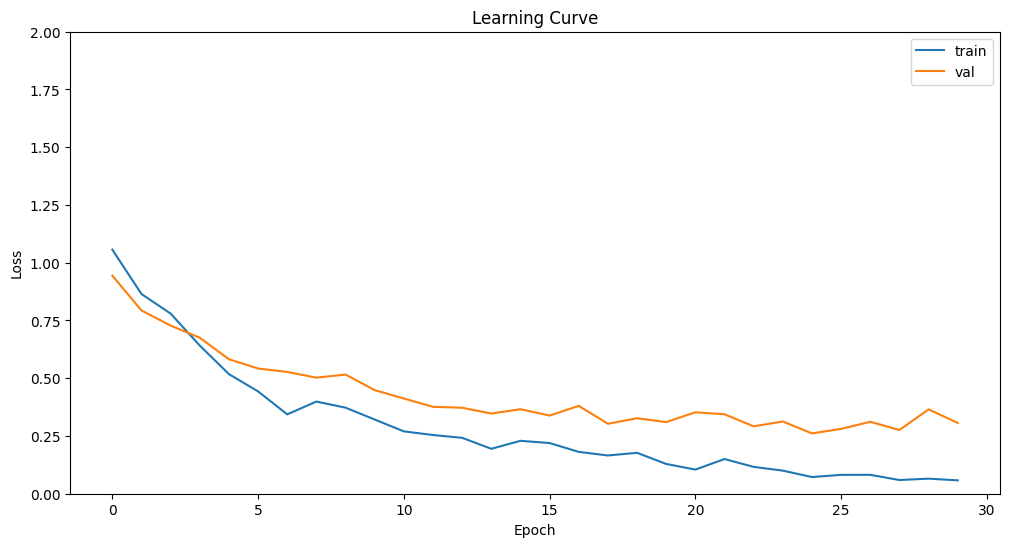

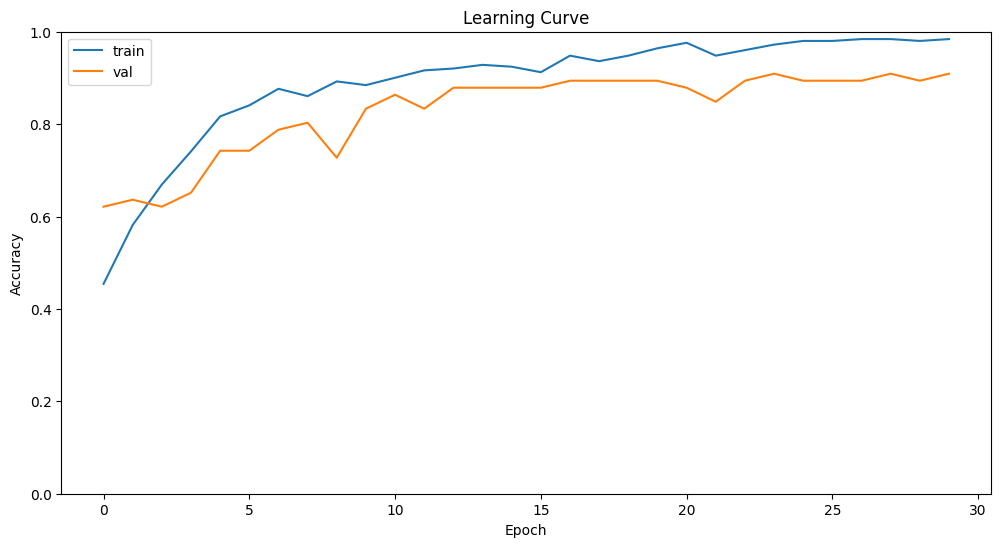

In [97]:
learning_curve(history,'loss', ylim=(0,2))
learning_curve(history, 'accuracy', ylim=(0,1))

In [98]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

5/5 [==============================] - 2s 199ms/step - loss: 0.2610 - accuracy: 0.8939
Loss: 26.100
Accuracy: 89.394


**We got a good model with an accuracry of 95%**

In [80]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

5/5 [==============================] - 1s 202ms/step


(array([2, 0, 0, 1, 2, 1, 2, 1, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2,
        1, 2, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 0, 2, 1, 0, 1, 1,
        0, 2, 2, 0, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=int32))

In [81]:
classes = []
for i in os.listdir(test_path):
    classes+=[i]

classes

['Viral Pneumonia', 'Normal', 'Covid']

### Function To Calculate F1-Score

In [82]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

### Function To Plot Confusion Matrix

In [83]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('./img1.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

### Function To Calculate Confusion Matrix

In [84]:
def cal_score(model, key):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if key==1:
        confusion_matrix_plot(matrix)

[[ 7  7  7]
 [ 4  4  9]
 [ 9  9 10]]


F1 Score: 0.32146632959641086


                 precision    recall  f1-score   support

Viral Pneumonia       0.35      0.33      0.34        21
         Normal       0.20      0.24      0.22        17
          Covid       0.38      0.36      0.37        28

       accuracy                           0.32        66
      macro avg       0.31      0.31      0.31        66
   weighted avg       0.33      0.32      0.32        66



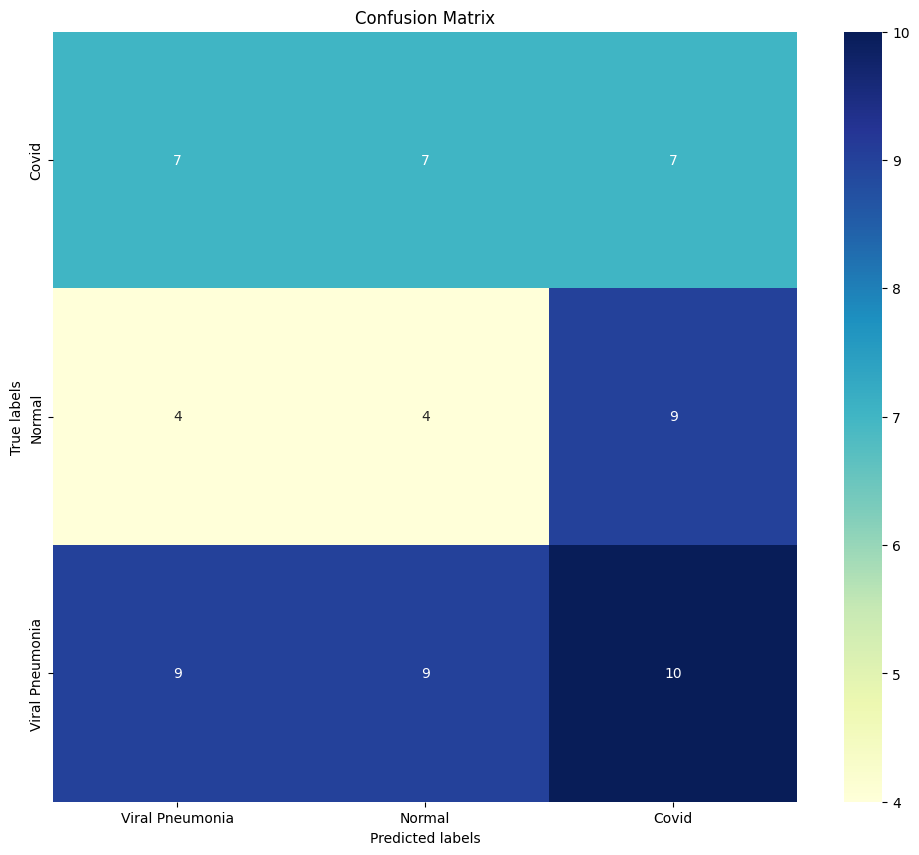

In [85]:
cal_score(model, 1)